In [1]:
%matplotlib widget

import os
import sys
import matplotlib.pyplot as plt
import torch
import numpy as np
torch.multiprocessing.set_sharing_strategy('file_system')

sys.path.append("../core")
from model import CAI_Model

sys.path.append(os.path.abspath("/develop/code/cai_2023/evaluation"))
import eval_methods as em

sys.path.append(os.path.abspath("/develop/code/cai_2023/resim"))
#import launch_resim as launch

path_results = "/develop/results"

plt.style.use('seaborn-v0_8-poster')

Global seed set to 1337


In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [3]:
folder_name = "model_fullTrain"

In [4]:
import pickle
def get_results(folder_name,target):

    train_path = os.path.join(path_results, folder_name, "train_info")
    valid_path = os.path.join(path_results, folder_name, "valid_info")

    train_results = pickle.load(open(os.path.join(train_path,target),"rb"))
    valid_results = pickle.load(open(os.path.join(valid_path,target),"rb"))
    
    return train_results, valid_results

In [5]:
recon_train_results, recon_valid_results = get_results(folder_name,"recon.pkl")

In [6]:
recon_train_results.keys()

dict_keys(['nf_amp_diff', 'nf_angle_diff', 'ff_amp_diff', 'ff_angle_diff'])

In [7]:
colors = ['darkgreen','purple','#4e88d9'] 
def set_box_color(bp, color, linestyle, linewidth = 2):
    plt.setp(bp['boxes'], color=color, linewidth=linewidth,  linestyle=linestyle)
    plt.setp(bp['whiskers'], color=color, linewidth=linewidth, linestyle=linestyle)
    plt.setp(bp['caps'], color=color, linewidth=linewidth)
    plt.setp(bp['medians'], color=color, linewidth=linewidth)

def set_violin_color(vp, color):
    for pc in vp['bodies']:    
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_linewidth(4)

    # for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    #     part = vp[partname]
    #     part.set_edgecolor(color)
    #     if 'mean' in partname:
    #         part.set_linestyle('dotted')
    #     #part.set_linewidth(1)

In [8]:
def box_plots(nf_amp_diff, nf_angle_diff, ff_amp_diff, ff_angle_diff, dataset):
    
    num_models = 2       # (integer) This sets how many boxes next to each other per index
    buffer = 0.5         # (float)   This sets the spacing between boxes for the same index
    num_values =  2      # (integer) This sets the number of indices (9 for phase, 6 for curvature)
    position_offset = 1  # (integer) This sets the offset of the indices - increase if neighboring 'groups' are too close
    fontsize = 14

    pos = np.array(range(num_values))*(num_models+position_offset) 
    fig,ax = plt.subplots(1,1,figsize=(8,5))

    nf_amp_diff = np.mean(nf_amp_diff, axis=(1,2))
    nf_angle_diff = np.mean(nf_angle_diff, axis=(1,2))
    bp0 = ax.boxplot((nf_amp_diff, nf_angle_diff), sym='', positions = pos - buffer, widths=0.6)
    vp0 = ax.violinplot((nf_amp_diff, nf_angle_diff), positions = pos - buffer, widths=0.6, showmeans=False, quantiles=None, showmedians=False, showextrema=False, points=len(nf_amp_diff))

    ff_amp_diff = np.mean(ff_amp_diff, axis=(1,2))
    ff_angle_diff = np.mean(ff_angle_diff, axis=(1,2))
    bp1 = ax.boxplot((ff_amp_diff, ff_angle_diff), sym='', positions = pos + buffer, widths=0.6)
    vp1 = ax.violinplot((ff_amp_diff, ff_angle_diff), positions = pos + buffer, widths=0.6, showmeans=False, quantiles=None, showmedians=False, showextrema=False, points=len(nf_amp_diff))

    set_box_color(bp0, colors[0], 'solid')
    set_box_color(bp1, colors[1], 'solid')

    set_violin_color(vp0, colors[0])
    set_violin_color(vp1, colors[1])


    # ax.set_ylabel("Phase Difference", fontsize=fontsize)
    # ax.set_xlabel("Phase Index", fontsize=fontsize)
    
    ax.tick_params(axis='both', labelsize=fontsize)
    
    ax.set_xticks(range(0, 2*(num_models+position_offset), (num_models+position_offset)))
    ax.set_xticklabels(['Near Field', 'Far Field'])
    ax.set_xlim(-(buffer*2), 2*((num_models)+position_offset)-(buffer*2))
    ax.set_ylim(-0.1,4)
    ax.grid(axis='x', which='both', linewidth=0)  # Set linewidth to 0 to hide the grid lines
    ax.grid(axis='y', which='both', linewidth=1, linestyle='--', color='black', alpha=0.7)  # Set linewidth to 0 to hide the grid lines

    ax.set_ylabel("Average absolute difference")
    
    #Gotta do this to get the legend
    #Plots empty lines with the correct color and linestyle to match. We will use these in the legend. 
    ln0, = ax.plot([], c=colors[0], label='Amplitude', linestyle = 'solid')
    ln1, = ax.plot([], c=colors[1], label='Phase', linestyle = 'solid')
    leg = ax.legend(handles = [ln0, ln1] , loc='upper left', frameon = True)

    leg.get_frame().set_edgecolor('gray')

    ax.set_title("Reconstruction : {}".format(dataset))
    
    plt.tight_layout()
    fig.savefig("recon_boxplot_{}.pdf".format(dataset))
    plt.show()

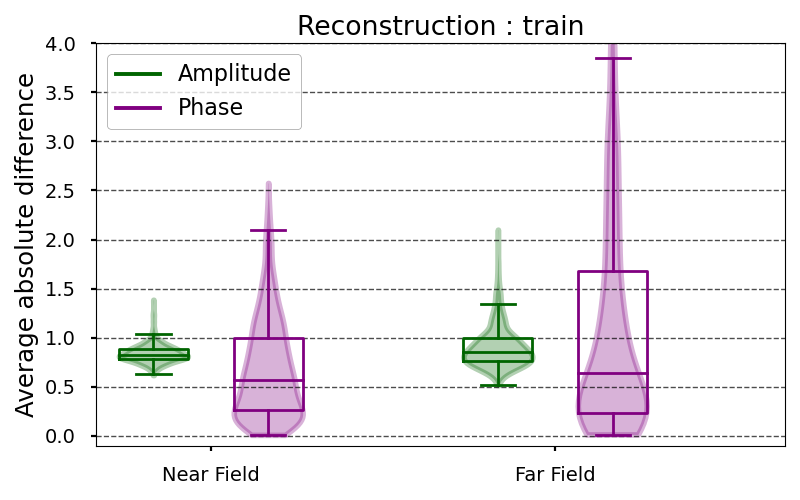

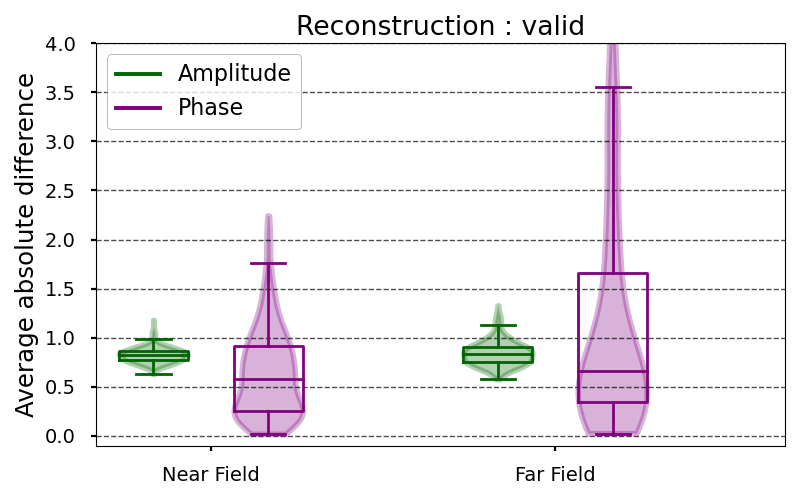

In [9]:
plt.close('all')
box_plots(recon_train_results['nf_amp_diff'], recon_train_results['nf_angle_diff'], recon_train_results['ff_amp_diff'], recon_train_results['ff_angle_diff'], 'train')
box_plots(recon_valid_results['nf_amp_diff'], recon_valid_results['nf_angle_diff'], recon_valid_results['ff_amp_diff'], recon_valid_results['ff_angle_diff'], 'valid')


---
---
---


In [10]:
#Now for combined loss plots
encoder_folder_name = "model_baselineEncoder"
tuning_folder_name = "model_baseline_phases_derivatives"
fullTrain_folder_name = "model_fullTrain"

combined_loss= []
folder_path = os.path.join(path_results, encoder_folder_name)
single_loss = em.gather_loss(folder_path)['loss']['train_total_loss']
single_loss = [single_loss[i] for i,_ in enumerate(single_loss) if i %2 !=0]
combined_loss.append(single_loss)

folder_path = os.path.join(path_results, tuning_folder_name)
single_loss = em.gather_loss(folder_path)['loss']['train_total_loss']
single_loss = [single_loss[i] for i,_ in enumerate(single_loss) if i %2 !=0]

combined_loss.append(single_loss)

folder_path = os.path.join(path_results, fullTrain_folder_name)
single_loss = em.gather_loss(folder_path)['loss']['train_total_loss']
single_loss = [single_loss[i] for i,_ in enumerate(single_loss) if i %2 !=0]

combined_loss.append(single_loss)
combined_loss = np.asarray(combined_loss)
combined_loss_train = np.concatenate(combined_loss)

#Now for combined loss plots
encoder_folder_name = "model_baselineEncoder"
tuning_folder_name = "model_baseline_phases_derivatives"
fullTrain_folder_name = "model_fullTrain"

combined_loss= []
folder_path = os.path.join(path_results, encoder_folder_name)
single_loss = em.gather_loss(folder_path)['loss']['val_total_loss']
single_loss = [single_loss[i] for i,_ in enumerate(single_loss) if i %2 ==0]
combined_loss.append(single_loss)

folder_path = os.path.join(path_results, tuning_folder_name)
single_loss = em.gather_loss(folder_path)['loss']['val_total_loss']
single_loss = [single_loss[i] for i,_ in enumerate(single_loss) if i %2 ==0]

combined_loss.append(single_loss)

folder_path = os.path.join(path_results, fullTrain_folder_name)
single_loss = em.gather_loss(folder_path)['loss']['val_total_loss']
single_loss = [single_loss[i] for i,_ in enumerate(single_loss) if i %2 ==0]

combined_loss.append(single_loss)
combined_loss = np.asarray(combined_loss)
combined_loss_val = np.concatenate(combined_loss)

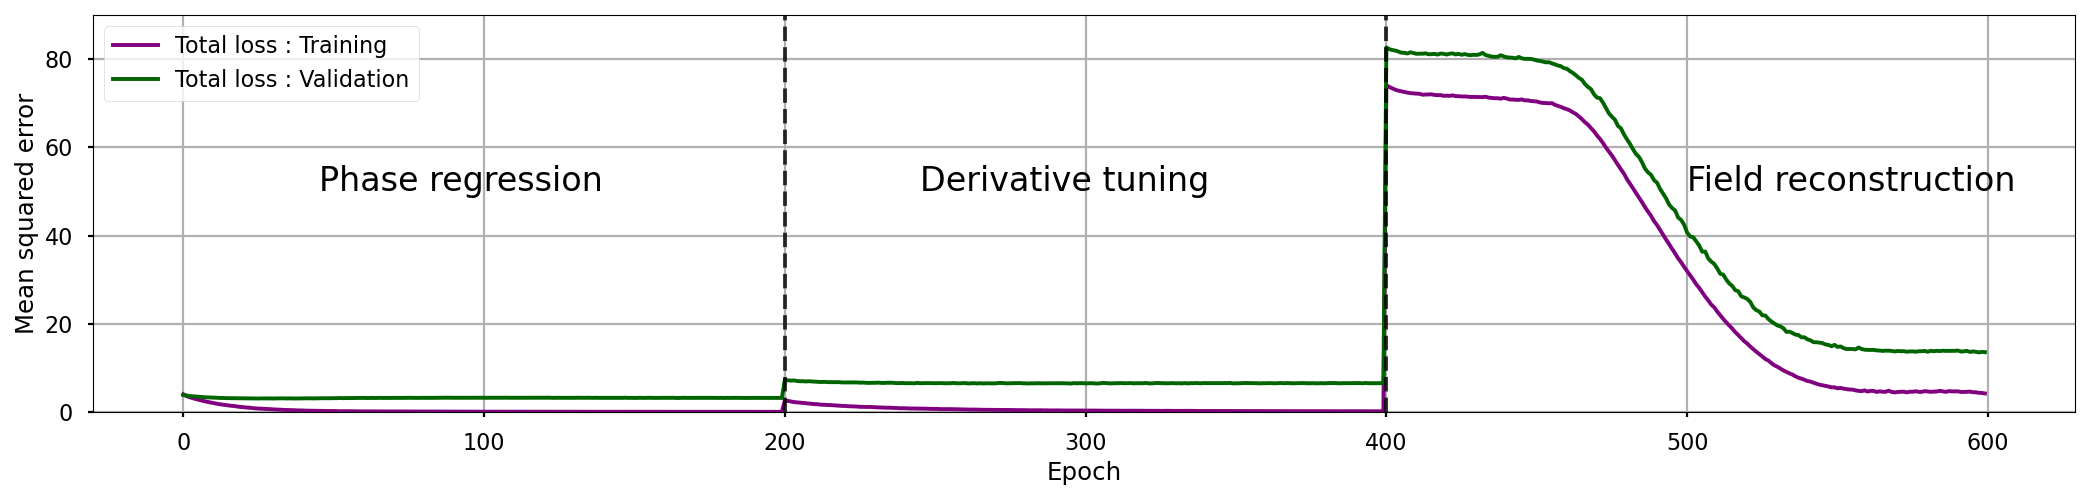

In [11]:
fig,ax = plt.subplots(1,1,figsize=(21,5))
ln0, = ax.plot(combined_loss_train, color='purple', label='Total loss : Training')
ln1, = ax.plot(combined_loss_val, color='darkgreen', label='Total loss : Validation')

ax.vlines(x=200, ymin=0, ymax=90, color='black', linestyle='dashed', alpha=0.8)
ax.vlines(x=400, ymin=0, ymax=90, color='black', linestyle='dashed', alpha=0.8)

ax.annotate(xy=(45,50),text="Phase regression", fontsize=24)
ax.annotate(xy=(245,50),text="Derivative tuning", fontsize=24)
ax.annotate(xy=(500,50),text="Field reconstruction", fontsize=24)

ax.legend(loc='upper left', handles=[ln0,ln1])
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean squared error')
ax.set_ylim(0,90)
ax.grid(True)
plt.tight_layout()
fig.savefig('combined_loss.pdf')

In [12]:
for i, name in enumerate(loss.keys()):
        
        if(name == "epoch"):
            continue

        if(name.startswith('val')):
            #fig.suptitle(f"\nLoss Analysis {title}: " + "Valid Dataset", fontsize=fontsize, fontproperties=font)
            
            x_vals = loss["epoch"]
            x_vals = x_vals[x_vals.index % 2 == 0]
            y_vals = loss[name]
            y_vals = y_vals[y_vals.index % 2 == 0]
            
            ax[1][i].plot(x_vals, y_vals, color = colors[0], label=title)
            ax[1][i].set_ylabel("Loss", fontsize = fontsize-1)
            ax[1][i].set_xlabel("Epoch", fontsize = fontsize-1)
            ax[1][i].set_title(name,fontsize=fontsize+1)
            ax[1][i].tick_params(axis="x", labelsize=6)
            ax[1][i].tick_params(axis="y", labelsize=6)
            #ax[1][i].legend(loc='upper right', fontsize=fontsize)
            ax[1][i].set_ylim([min[i],max[i]])
            
        else:
            #fig.suptitle(f"\nLoss Analysis {title}: " + "Train Dataset", fontsize=fontsize, fontproperties=font)

            x_vals = loss["epoch"]
            x_vals = x_vals[x_vals.index % 2 != 0]
            y_vals = loss[name]
            y_vals = y_vals[y_vals.index % 2 != 0]
            
            ax[0][i-6].plot(x_vals, y_vals, color = colors[1], label=title)
            ax[0][i-6].set_ylabel("Loss", fontsize = fontsize-1)
            ax[0][i-6].set_xlabel("Epoch", fontsize = fontsize-1)
            ax[0][i-6].set_title(name,fontsize=fontsize+1)
            ax[0][i-6].tick_params(axis="x", labelsize=6)
            ax[0][i-6].tick_params(axis="y", labelsize=6)
            ax[0][i-6].set_ylim([0,100])
            #ax[0][i-6].legend(loc='upper right', fontsize=fontsize)
            ax[0][i-6].set_ylim([min[i-6],max[i-6]])

NameError: name 'loss' is not defined

---
---
---

In [13]:
original = torch.from_numpy(np.random.rand(8,2,176,176))
recon = torch.from_numpy(np.random.rand(8,2,176,176))
resim = torch.from_numpy(np.random.rand(8,2,176,176))


from torchmetrics import PeakSignalNoiseRatio

In [14]:
psnr = PeakSignalNoiseRatio()
psnr(original[0,0,:,:], recon[0,0,:,:])

tensor(7.7756, dtype=torch.float64)

In [15]:
def calculate_matrix(original, recon, resim):
    
    original_vs_original = psnr(original, original)
    original_vs_recon = psnr(original, recon)
    original_vs_resim = psnr(original, resim)

    recon_vs_original = psnr(recon, original)
    recon_vs_recon = psnr(recon, recon)
    recon_vs_resim = psnr(recon, resim)

    resim_vs_original = psnr(resim, original)
    resim_vs_recon = psnr(resim, recon)
    resim_vs_resim = psnr(resim, resim)

    row0 = np.asarray([original_vs_original,original_vs_recon,original_vs_resim])
    row1 = np.asarray([recon_vs_original,recon_vs_recon,recon_vs_resim])
    row2 = np.asarray([resim_vs_original,resim_vs_recon,resim_vs_resim])

    conf_matrix = np.asarray([row0, row1, row2])

    conf_matrix[conf_matrix==np.inf] = 'NA'
    
    return conf_matrix

def build_psnr_conf_matrices(original, recon, resim):

    original_amplitude = original[:,0,:,:]
    recon_amplitude = recon[:,0,:,:]
    resim_amplitude = resim[:,0,:,:]

    original_phase = original[:,1,:,:]
    recon_phase = recon[:,1,:,:]
    resim_phase = resim[:,1,:,:]

    amplitude_conf_matrix = calculate_matrix(original_amplitude, recon_amplitude, resim_amplitude)
    phase_conf_matrix = calculate_matrix(original_phase, recon_phase, resim_phase)

    return amplitude_conf_matrix, phase_conf_matrix
    
    

In [16]:
amplitude_matrix, phase_matrix = build_psnr_conf_matrices(original, recon, resim)

ValueError: could not convert string to float: 'NA'

NameError: name 'amplitude_matrix' is not defined

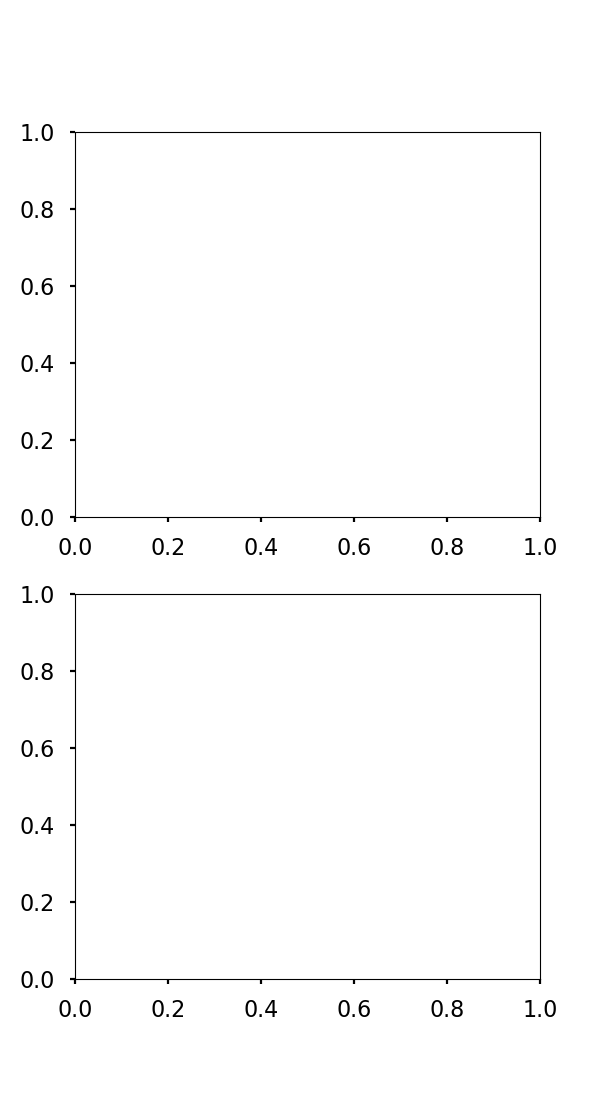

In [17]:
plt.close('all')
fig,ax = plt.subplots(2,1,figsize=(6,11))
ax[0].imshow(amplitude_matrix, cmap='turbo', alpha=1)
ax[0].set_title('Amplitude')

ax[1].imshow(phase_matrix, cmap='turbo', alpha=1)
ax[1].set_title('Phase')

ax[0].set_xticks([0,1,2])
ax[0].set_yticks([0,1,2])

ax[0].set_xticklabels(['Original', 'Recon', 'Resim'])
ax[0].set_yticklabels(['Original', 'Recon', 'Resim'])
ax[0].yaxis.tick_right()

ax[1].set_xticks([0,1,2])
ax[1].set_yticks([0,1,2])

ax[1].set_xticklabels(['Original', 'Recon', 'Resim'])
ax[1].set_yticklabels(['Original', 'Recon', 'Resim'])
ax[1].yaxis.tick_right()


for i in range(amplitude_matrix.shape[0]):
    for j in range(amplitude_matrix.shape[1]):
        ax[0].text(x=j, y=i,s=round(amplitude_matrix[i, j],2), va='center',ha='center', size='xx-large', color='white')


for i in range(phase_matrix.shape[0]):
    for j in range(phase_matrix.shape[1]):
        ax[1].text(x=j, y=i,s=round(phase_matrix[i, j],2), va='center',ha='center', size='xx-large', color='white')
        
plt.tight_layout()

---
---
---

In [ ]:
#Propagating near fields into the FF
import yaml
import sys
sys.path.append('/develop/code/')

from utils import parameter_manager
from core import propagator

params = yaml.load(open('../config.yaml', 'r'), Loader=yaml.FullLoader)
pm = parameter_manager.Parameter_Manager(params = params)

prop = propagator.Propagator(pm.params_propagator)

#prop(resim_nf)